# Лабораторная работа 4. Моделирование двумерных перколяционных кластеров

**Цель лабораторной работы:** ознакомиться с теорией перколяции для двух разных задач, проанализировать зависимости полученных порогв протекания для разных форм сеток

Данная лабораторная работа основывается на книге А.Л.Эфроса «Физика и геометрия беспорядка» (Библиотечка Квант) и подготовлена для курса «Наноматериалы», читаемого в весеннем семестре для магистров первого года. Часть материала, связанного с математической справкой, опущена с учетом прохождения студентами курса теории вероятностей и математической статистики.

# 1. Задача узлов

## 1.1. Квадратная сетка. Эксперимент Ватсона и Лиса

В эксперименте Ватсона и Лиса (Physical Review, 1974) был взят кусок экранной сетки квадратной формы, содержащий 137×137 = 18769 узлов. Исследователи припаяли к двум протиповоложным сторонам квадрата электроды и включили сетку в электрическую цепь, чтобы измерить ее сопротивление. Затем они стали блокировать выбранные случайным образом отдельные узлы и измерять зависимость электрического сопротивления от доли блокированных узлов. Блокировка узла состояла в том, что кусачками перерезались все четыре проволоки, связанные с этим узлом. По мере уменьшения доли неблокированных узлов $x$ электропроводность сетки уменьшалась. При некотором значении $x_c$ — пороге протекания, когда перерезался последний путь, связывающий левый и правый электроды, электропроводность обращалась в ноль. Было найдено, что для такой квадратной сетки $x_c = 0,59$. При помощи приведенного ниже кода мы предлагаем вам промоделировать эксперимент Ватсона и Лиса и сравнить получаемое значение порога протекания с результатами исследователей.

В представленной ниже функции для работы с сетками используется понятие графа. Граф — совокупность точек, соединенных линиями. Точки называются вершинами, или узлами, а линии – ребрами, или дугами. Для работы с графами в нашей программе используется библиотека Networkx.

In [2]:
'''
В этом блоке задается функция определения порога протекания для одного из трех типов сеток:
квадратной, треугольной или шестиугольной. При задании булевой переменной draw значения True,
функция также позволяет отобразить состояние сетки в момент образования перколяционного кластера.
'''

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import itertools
import random

matplotlib.rcParams.update({'font.size': 14})

def site_perc_threshold (N1, N2, Task='Node', grid='square', draw=False):
    '''Нахождение порога протекания для трех типов сеток: квадратной),
    треугольной и шестиугольной'''
    
    'задаем квадратную сетку'
    if grid == 'square':
        G = nx.grid_2d_graph(N1+2, N2) 
        pos = dict( (n, n) for n in G.nodes() ) 
        
    'задаем треугольную сетку'
    if grid == 'triangular':
        G = nx.triangular_lattice_graph(N1-1, 2*N2+2) 
        N1, N2 = N2, N1
        pos = nx.get_node_attributes(G, 'pos')
    
    X, Y = range(1, N1+1), range(N2)
    electrodes = [(0, j) for j in Y] + [(N1+1, j) for j in Y]
    
    'задаем гексагональную сетку'
    if grid == 'hexagonal':
        G = nx.hexagonal_lattice_graph(N1//2, N2+1)
        electrodes = [(0, j) for j in Y] + [(N2+1, j) for j in Y]
        if N2 % 2 == 1 and N1 % 2 == 1 :  
            electrodes = [(0, j) for j in Y] + [(N2+1, j+1) for j in Y]
        elif N2 % 2 == 1 and N1 % 2 == 0 :
            N1=N2
            X, Y = range(1, N1), range(N2)
            G = nx.hexagonal_lattice_graph(N1//2, N2+1)
            electrodes = [(0, j) for j in Y] + [(N1+1, j+1) for j in Y]
        elif N2 % 2 == 0 and N1 % 2 == 0 :
            G = nx.hexagonal_lattice_graph(N1//2-1, N2+1)
            electrodes = [(0, j) for j in Y] + [(N2+1, j) for j in Y]
        pos = nx.get_node_attributes(G, 'pos')
    
    sites = list(itertools.product(X, Y))  # координаты исходных узлов
    random.shuffle(sites)                  # перемешиваем координаты
    coords = sites + electrodes            # координаты решетки (с электродами)

    numbers_of_edges = len(dict(G.edges)) - (N2-1)*2    # Количество связей между электродами
    numbers_of_nodes = len(G)                           # Количество узлов 
    electrodes1 = electrodes[:]
    electrodes1.pop(0)
    electrodes_edges = list(zip( electrodes, electrodes1)) # Координаты связей между электродами
    all_edges = list(G.edges)
    all_edges_between_electrodes = list(set(all_edges) - set(electrodes_edges))
                                    
    'удаляем случайные узлы/связи, пока имеется путь между электродами'
    while nx.algorithms.shortest_paths.generic.has_path(G, (0,1), (N1+1, 1)):
        if Task == 'Nodes':
            a = sites.pop() 
            neighbors = G.neighbors(a)     # запоминаем соседей последнего убранного узла
            G.remove_node(a)                 # удаляем узел
            
        if Task == 'Edges':
            edges = random.choice(all_edges_between_electrodes) # Выбираем случайный узел между электродами
            G.remove_edge(edges[0],edges[1])   
            all_edges_between_electrodes.remove(edges)
            
    if Task == 'Edges':
        x_c = (len(G.edges) - (N2-1)*2)/(numbers_of_edges)     # находим порог протекания для задачи связей
        G.add_edge(edges[0],edges[1])                          # для построения пути добавляем последний убранный узел
            
    if len(list(nx.isolates(G))) != 0:                         # удаляем узлы у которых нет связей с соседними узлами
        G.remove_nodes_from(list(nx.isolates(G)))
        
    if Task == 'Nodes':
        x_c = (len(G)-2*N2)/(N1*N2)                            # находим порог протекания для задачи узлов
        if grid == 'hexagonal':
            x_c = (len(G) - (N2-1)*2-2)/(numbers_of_nodes - (N2-1)*2-2)  # находим порог протекания для гексагональной сетки
        
    'в случае необходимости построения изображения'
    if draw:
        plt.figure(figsize=(10, 10))         # строим изображение заданного размера
        plt.xticks([]), plt.yticks([])       # скрываем засечки координатных осей
        
        nodelist = list(dict(((n, n) for n in electrodes )))         # координаты узлов электродов
        
        if Task == 'Nodes':
            G.add_node(a)         # для построения пути добавляем последний убранный узел
            for i in neighbors:   # строим связи к последнему убранному узлу
                G.add_edge(i, a)
            
        isolated = []
        
        'находим узлы, не имеющие пути к электроду'
        for node in dict(G.nodes()): 
            if not nx.algorithms.shortest_paths.generic.has_path(G, (0,1), node):
                isolated.append(node)  #добавляем найденный узел в список
                
        #окрашиваем путь и электроды       
        shortestPath_electrodes = list(nx.shortest_path(G, (0,0), (N1+1, 1))) + list(dict(((n, n) for n in electrodes )))
        node_colors = list(["b" if n in shortestPath_electrodes else "r" for n in G.nodes()])
        
        #строим график (узлы и связи между ними) и окрышиваем их
        nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_colors)
        nx.draw_networkx_nodes(G, pos, node_size=50, nodelist=isolated, node_color='grey')
        nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10)
    
    return round(x_c, 2)

**Задание**:
- Запустите последовательно три следующие ячейки для расчета и отображения перколяционных кластеров на трех типах решеток: соответственно квадратной, треугольной и шестиугольной. Расчет занимает достаточно длительное время. В процессе получения результата вы можете ознакомиться с следующими теоретическими разделами.

Белым цветом отображено пространство блокированных (вырезанных узлов). Красным окрашены проводящие узлы, соединенные с электродами непрерывными цепочками из неблокированных узлов. Синий цвет соответствует цепочке неблокированных узлов, образующих проводящий путь между двумя электродами, так же окрашенных в синий. «Выпавшие» из процесса электропроводности изолированные кластеры неблокированных узлов обозначены серым цветом.

0.56


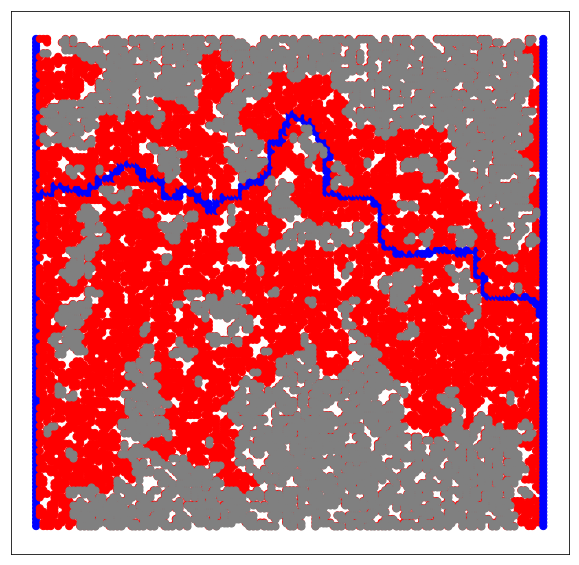

In [6]:
# квадратная решетка
print(site_perc_threshold(137, 137, Task = 'Nodes', grid = 'square', draw = True))

0.49


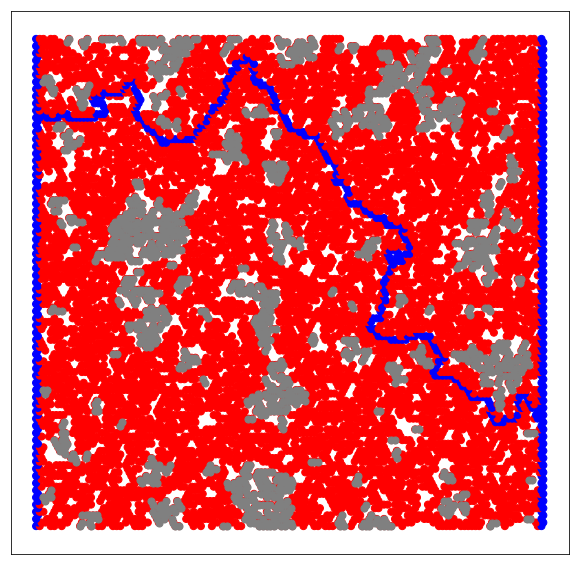

In [7]:
# треугольная решетка
print(site_perc_threshold(137, 137, Task = 'Nodes', grid = 'triangular', draw = True))

0.7


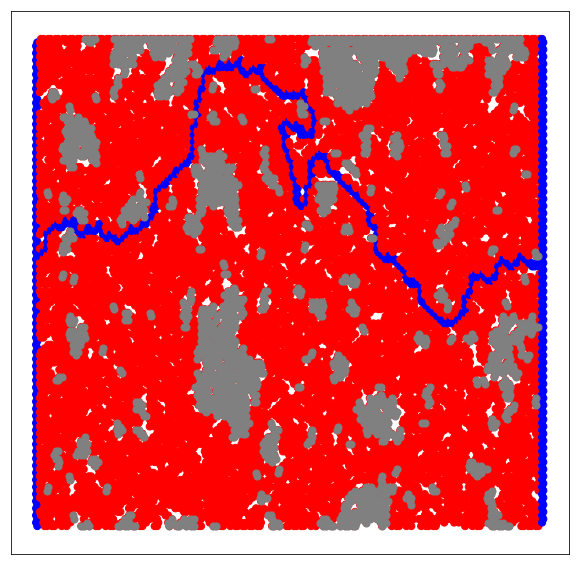

In [8]:
# шестиугольная решетка
print(site_perc_threshold(137, 137, Task = 'Nodes', grid = 'hexagonal', draw = True))

**Задания**:
- Запишите в протокол под п. 1.1 полученные значения порога протекания на каждом типе решетки. Сравните полученное значение порога протекания для квадратной сетки с экспериментальным значением из опыта Ватсона и Лиса.
- Чтобы проверить случайный характер перколяционного кластера, проведите расчет при одних и тех же размерах (исходно это 100х100) несколько раз и сравните значения порога протекания. 
- Проварьируйте размер сетки, задав значения $N \in [10, 100]$. В случае, если размер сетки выбран таким, что расчет длится слишком долго, остановите вычисление и рассмотрите интервал меньших значений.

Как мы видим из проведенных экспериментов, порог протекания $x_c$ для сетки конечных размеров является случайной величиной. Действительно, поскольку конфиуграция блокированных и целых узлов в каждом эксперименте для одной и той же решетки нисколько не похожа на конфигурацию другого эксперимента, то разрыв последнего пути, соединяющего электроды, должен происходить при различных долях неблокированных узлов $x$.

## 1.2. Средняя величина и СКО

Изучим «средние» свойства величины $x_c$, то есть свойства, проявляющиеся в достаточно большом количестве экспериментов, выполненных при одинаковых условиях (одинаковом числе узлов сетки и одной природе генератора случайных чисел). Выполнив $Q$ экспериментов с сеткой из $N$ узлов, мы получим $Q$ значений порога протекания $x_i$. Тогда среднее арифмитическое $\overline{x}_Q$ всех $x_i$, полученных в $Q$ экспериментов:

$$\overline{x}_Q = \dfrac{1}{Q}\sum_{i=1}^{Q}{x_i}.$$

Величина $\overline{x}_Q$ всё еще является случайной. Если сделать еще одну серию из $Q$ опытов в тех же самых условиях и по их результатам снова вычислить $\overline{x}_Q$, то оно окажется несколько иным. Однако чем больше число опытов $Q$, тем меньше отличаются друг от друга средние значения, взятые по разным сериям. Случайные колебания величин $x_i$ в сумме компенсируют друг друга, так что с ростом $Q$ величина $\overline{x}_Q$ стремится к вполне определенному (и не зависящему от $Q$) значению. Это предельное значение называется *средним значением случайной величины*.

Обозначим через $x_c (N)$ среднее значение порога протекания для сетки из $N$ узлов. Величина $x_c (N)$ является не случайной, а достоверной. Рассмотрим ее зависимость от $N$. Отклонения случайной величины от среднего значения обозначим $\delta_i$, а дисперсию и среднее квадратичное отклонение соответственно $\delta^2(N)$ и $\delta(N)$:

$$\delta_i = x_i - x_c,$$

$$\delta^2(N) = \dfrac{1}{Q}\sum_{i=1}^{Q}{\delta_i^2},$$

$$\delta(N) = \sqrt{\delta^2(N)}.$$

Величина $\delta(N)$ уменьшается по степенном закону с ростом числа узлов $N$, стремясь к нулю при $N \rightarrow \infty$:

$$\delta(N) = CN^{-\frac{\nu}{2}},$$

где $C$ и $\nu$ – две независимые от $N$ величины. Величина $\nu$ называется индексом радиуса корреляции.

В то же время для нахождения истинного порога протекания используется следующая аппроксимация:

$$x_c(N) = x_c(\infty) + DN^{-\gamma}$$


Чтобы исследовать поведение среднего значения порога протекания и определить величины $C$, $\nu$, $D$, $\gamma$, при помощи кода ниже построим зависимости $x_c(N)$ и $\delta(N)$.

Для более точных результатов нужно рассмотреть пороги протекания для сеток с большим значениям узлов, но на это потребуется большее время. Поэтому предлагаем вам взять из памяти ранее расчитанные коэффициенты (take_from_memory = True) для сеток с количесвом узлов от (3×3) до (59×59).

In [3]:
%matplotlib inline

import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import root
from scipy.optimize import curve_fit

from matplotlib import pyplot as plt
from PIL import Image
import sys
import csv
import pandas as pd



def threshold_curve(Task, grid, Q, take_from_memory = False):
           
    a=16
    if take_from_memory == True:
        a = 60    
    
    n=np.arange(3, a, 2)
    N = n**2
    x_new = np.arange((N[0]), (N[-1]+1))
    
    if take_from_memory == True:
        df = pd.read_csv("Percolation.csv", index_col = False)
        x_c = list(df['x_c_'+str(Task)+'_'+str(grid)])
        delta = list(df['delta_'+str(Task)+'_'+str(grid)])

    elif take_from_memory == False:
         # массив из Q повторений для каждого N
        x = np.array([[site_perc_threshold(n_i, n_i, Task, grid, draw=False) for i in range(Q)] for n_i in n])
        x_c = np.average(x, axis=1)  # средние значения для каждого N
        delta = np.std(x, axis=1)    # среднеквадратичные отклонения для каждого N

    def interpld(Y):
        return interp1d(N, Y, kind = 'cubic')

    d_N, x_N = interpld(delta), interpld(x_c)
        
    x_max=(x_N(N[-1]))
        
    '''Расчет С и v коэффициентов '''
    def D_N(arguments):
        c, v = arguments[0], arguments[1] 
        out = d_N(N)-c*(N)**(-v/2)
        return out
    result_d = root(D_N, [0.1, 0.1], method='lm')
        
    '''Расчет D и y коэффициентов'''        
    def X_N(arguments):
        d, y = arguments[0], arguments[1] 
        out = x_N(x_new)-d*(x_new)**(-y)-x_max
        return out
    result_x = root(X_N, [0.1, 0.1], method='lm')

    C, v , D, y = result_d.x[0], result_d.x[1], result_x.x[0], result_x.x[1]
    
    y_new, d_new = D*(x_new)**(-y)+x_max, C*(x_new)**(-v/2)
        
    '''Задаем функцию для построения графиков'''
    def plot(X, Y, X1, Y1, Title, Legend1, Legend2, xlabel, ylabel, b):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(X, Y, 'o', X1, Y1, '-')
        #добавляем легенду, оси и заголовок
        lgd = ax.legend( [Legend1, Legend2], loc='center right', bbox_to_anchor=(b, 0.5))
        ax.set_title(Title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel) 
       
    # Строим графики
    plot(N, x_c, x_new, y_new, Title='Cреднее значение порога протекания для сетки из $N$ узлов', Legend1='$x_c$', 
     Legend2='$x_c(N) =$'"%.2f" %  x_max + ' + ' "%.2f" %  D + 'N^('"%.2f" %  -y +')', xlabel='$N$', ylabel='$x_c$', b=1.7)
    plot(X =N, Y= delta, X1=x_new, Y1=d_new, Title='Отклонения случайной величины от среднего значения порога протекания для сетки из $N$ узлов', Legend1='$\delta$', 
     Legend2='$\delta(N) =$' "%.2f" %  C + ' N^(-'"%.2f" %  (v/2)+')', xlabel='$N$', ylabel='$\delta$', b=1.55)
    

Wall time: 48 ms


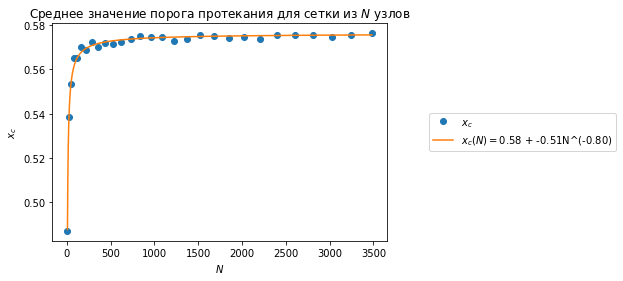

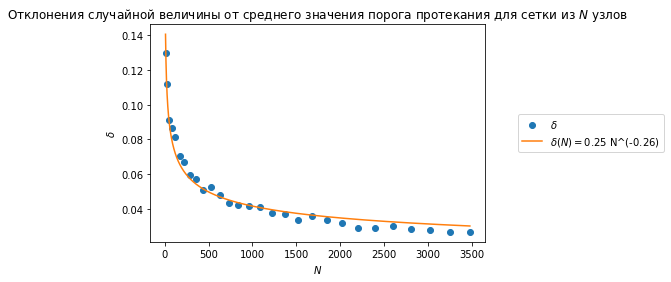

In [7]:
%%time
#Квадратная сетка
threshold_curve('Nodes', 'square', 1000, take_from_memory = True)

Wall time: 43 ms


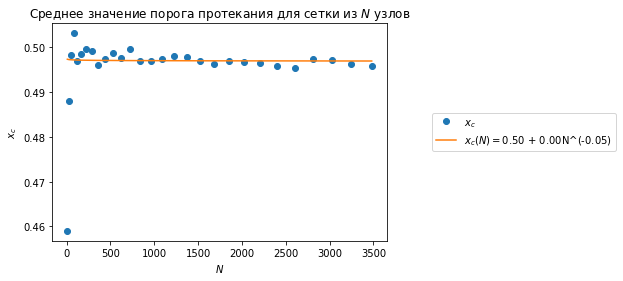

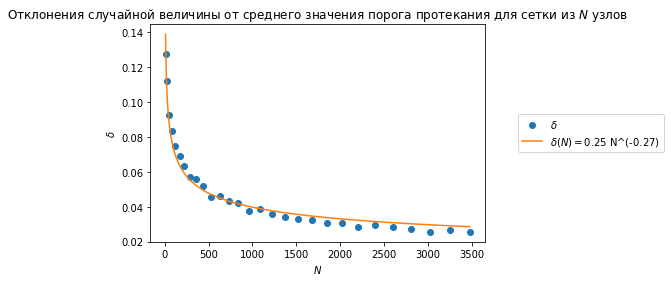

In [8]:
%%time
# треугольная решетка
threshold_curve('Nodes', 'triangular', 1000, take_from_memory = True)

Wall time: 41 ms


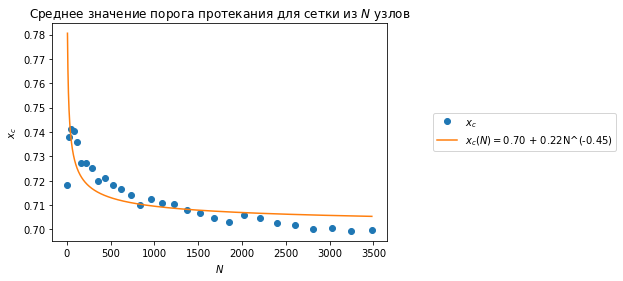

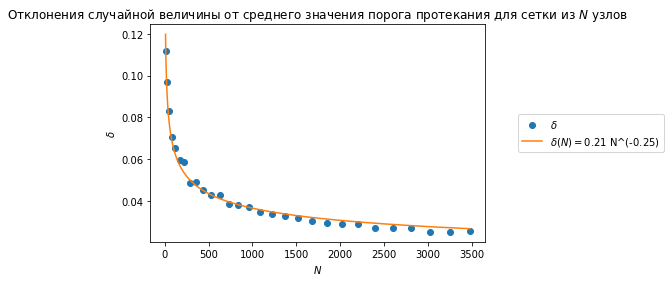

In [9]:
%%time
# шестиугольная решетка
threshold_curve('Nodes', 'hexagonal', 1000, take_from_memory = True)

В бесконечной системе справедливо представление о четко определенном пороге протекания, не зависящем от того, какая случайная последовательность блокированных узлов использовалась в эксперименте. В конечной системе четко определенного порога не существует, а имеется критическая область с шириной порядка $\delta(N)$, в которую попадают значения $x_c$, полученные в большинстве экспериментов с различными случайными последовательностями. С увеличением размеров системы эта область стягивается в точку.

# 2. Задача связей

Задача, которую решали Ватсон и Лис, называется задачей узлов в силу того, что именно узлы являются случайными элементами. В задаче связей случайными элементами являются связи. Будем называть два узла связанными, если между ними имеется целая связь или если они соединены непрерывной цепочкой связанных узлов. Совокупность связанных узлов называют кластером.

Долю неразорванных связей обозначим $x$. При малых значениях $x$ неразорванные связи располагаются по одиночке, почти все кластеры состоят из двух узлов. При больших значениях $x$ существует бесконечный кластер из связанных узлов. С уменьшением $x$ часть узлов из него выпадает и при некотором критическом значении $x_c$ бесконечный кластер прекращает свое существование.

На первый взгляд задача связей похожа на задачу узлов, однако для заданной решетки задачи друг к другу не сводятся и имеют разные ответы. 

Обозначим порог протекания задачи узлов (англ. sites) через $x_{У}$, а порог протекания задачи связей (англ. bonds) через $x_{СВ}$. Примем следующие сокращенные обозначения для названий плоских решеток: К – квадратная, Т – треугольная, Г – гексагональная.
В случае задачи связей такого рода исследования удобно делать с помощью понятия дуальной решётки.

Задачу связей удобно исследовать с помощью понятия дуальной решетки.
Решётка $L^Д$ называется дуальной к решётке $L$, если каждая связь $L^Д$ пересекает одну и только одну связь решётки $L$, и, наоборот, каждая связь $L$ пересекает одну и только одну связь $L^Д$. Дуальная решетка — это плоская решетка. Под плоскими решётками понимают такие решётки, которые могут быть размещены в плоскости, причем так, что связи решётки пересекаются только в тех точках, где находятся узлы решётки.А покрывающая решётка — не плоская, потому что в местах,показанных дугами, её связи пересекаются, а узлов в точках пе-
ресечения нет. (Дуги представляют собой как бы мосты, обеспечивающие развязку путей, идущих слева направо и сверху вниз.)

Как видно из определения, свойство дуальности является взаимным: если $L^Д$ дуальна к $L$, то $L$ дуальна к $L^Д$. Не сложно догадаться, что квадратная решётка является дуальной квадратной решётке, а треугольная и шестиугольная решётки дуальны друг другу. 

Вернёмся теперь к задаче связей. Примем, что если некоторая связь на исходной решётке белая (неразорванная), то пересекающая её связь на дуальной решётке чёрная (разорванная). Поэтому
если концентрация белых связей на исходной решётке равна х, то концентрация белых связей на дуальной решётке $q = 1 — х.$

То есть, если белая связь исходной решётки по определению пересекается только чёрной связью дуальной решётки, то на исходной решётке существует нигде не обрывающаяся ломаная линия из белых связей, пересекающая всю сетку слева направо. Если решетка достаточно велика, то наличие пути слева направо по исходной решётке означает, что доля белых связей больше пороговой:

$$ x \le x_\text{св}(L).$$

Отсутствие же пути сверху вниз по белым связям дуальной решётки означает, что доля белых связей дуальной решётки $q = 1 — х$ меньше пороговой доли для дуальной решётки:

$$ 1 - х \le x_\text{св}(L^Д),$$ и $$1 \le x_\text{св}(L) + x_\text{св}(L^Д). $$


Для квадратной решётки $L = L^Д$, и из неравенства следует, что

$$ 0.5 \le x_\text{св}(K).$$

А зная
$$ x_\text{св}(K) \le x_\text{у}(K),$$
то
$$ 0.5 \le x_\text{у}(K).$$

Для двух решёток — квадратной и треугольной — строго доказано, что знак неравенства в формуле следует заменить
знаком равенства (Но строгое доказательство этого равенства не приводится):

$$ x_\text{св}(L) + x_\text{св}(L^Д) = 1.$$

А отсюда вытекают два новых результата:

$$x_\text{св}(K) = 0.5,$$
и$$x_\text{св}(Т) + x_\text{св}(Ш) = 1. $$

Используя известную в теории электрических цепей преобразованием «звезда — треугольник», можно получить ещё одно соотношение, связывающее пороги протекания задачи связей на треугольной и шестиугольной решётках. В результате становится известным каждый из порогов:

$$ x_\text{св}(Т) = 2 sin(\dfrac{П}{18}) = 0.347296,$$
$$ x_\text{св}(Ш) = 1 - x_\text{св}(Т) = 1 - 2 sin(\dfrac{П}{18}) = 0.652704.$$




0.49


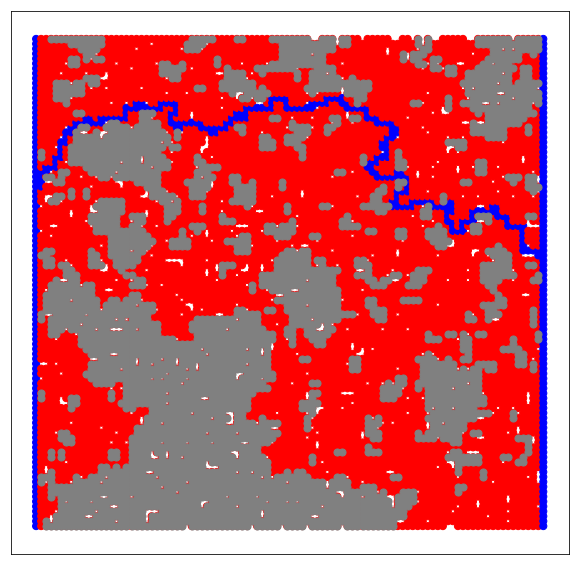

In [7]:
# квадратная решетка
print(site_perc_threshold(100, 100, Task = 'Edges', grid = 'square', draw = True))

Wall time: 54 ms


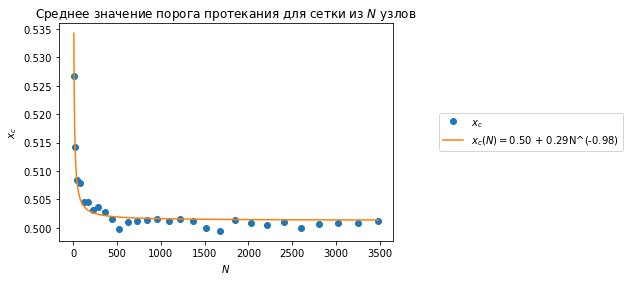

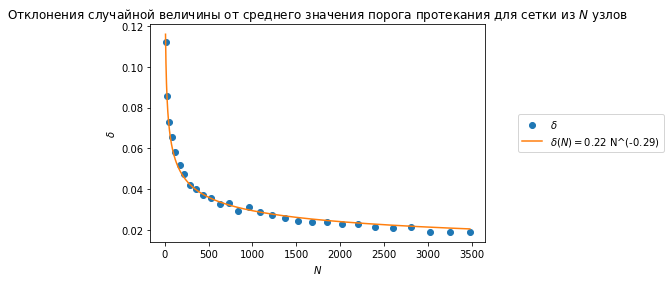

In [11]:
%%time
#Средняя величина и СКО квадратной решетки
threshold_curve( 'Edges' , 'square', 1000, take_from_memory = True)

In [ ]:
# треугольная решетка
print(site_perc_threshold(100, 100, Task = 'Edges', grid = 'triangular', draw = True))

Wall time: 56 ms


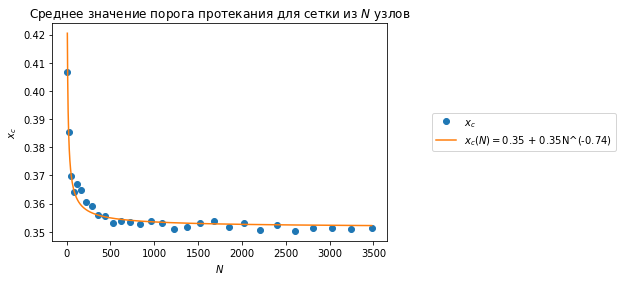

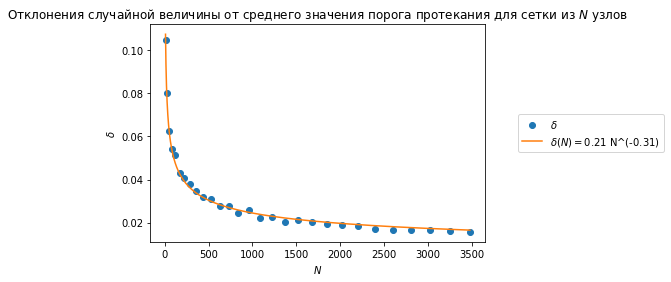

In [4]:
%%time
#Средняя величина и СКО треугольной решетки
threshold_curve( 'Edges' , 'triangular', 500, take_from_memory = True)

0.65


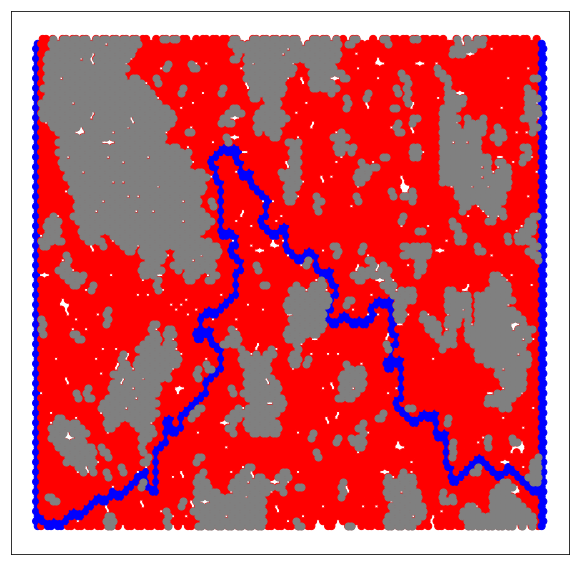

In [12]:
# шестиугольная решетка
print(site_perc_threshold(100, 100, Task = 'Edges', grid = 'hexagonal', draw = True))

Wall time: 39 ms


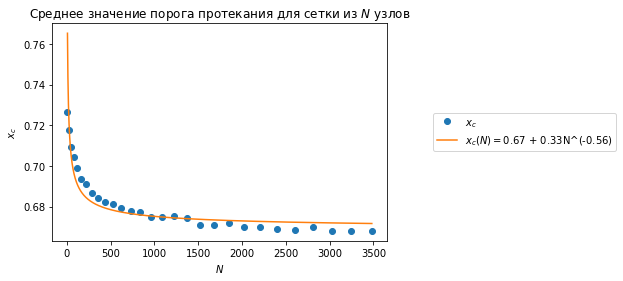

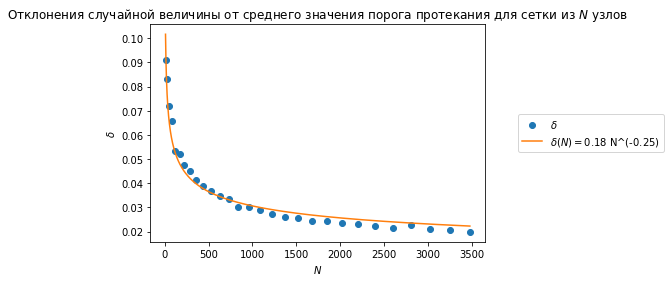

In [5]:
%%time
#Средняя величина и СКО шестиугольной решетки
threshold_curve( 'Edges' , 'hexagonal', 1000, take_from_memory = True)

## 2.1. Связь $x_\text{у}$ и $x_\text{св}$

При обсуждении задачи узлов вместо функции $P(x)$ часто вводят функцию $P_\text{y}(x)$, связанную с $P(x)$ соотношением

$$P(x) = xP_\text{y}(x)$$

По определению $P(x)$ – вероятность того, что выбранный наугад узел принадлежит бесконечному кластеру. Ее можно представить как произведение вероятностей двух независимых событий:
-  $x$ - вероятность того, что выбранный наугад узел неблокированный, то есть отношение числа неблокированных узлов к общему числу узлов
- $P_\text{y}(x)$ - вероятность того, что этот неблокированный узел связан с бесконечным кластером. Соответственно это отношение числа узлов, входящих в бесконечный кластер к общему числу неблокированных узлов.

Английский математик Хаммерсли доказал теорему, согласно которой:

$$P_\text{y}(x) \le P_\text{св}(x)$$

Обе функции $P_\text{y}(x)$ и $P_\text{y}(св)$ монотонно возрастают с увеличением $x$, поэтому пороги протекания для одного и того же типа решеток связаны обратным образом, т.е. порог в задачи связей не больше, чем в задаче узлов:

$$x_\text{св} \le x_\text{у}.$$

Неравенство означает, что, вырезая узлы, заблокировать систему легче, чем разрезая связи. Доля блокированных узлов, при которой прекращается ток, меньше, чем доля разорванных связей. Результат этого представляется совершенно естественным, так как при блокировании одного узла разрывается не одна связь, а все связи, входящие в этот узел.



# 3. Результаты для плоских решеток
### Сводная таблица порогов протекания для плоских решеток

|  Тип решетки  |  $$x_\text{св}$$  |  $$x_\text{у}$$ |
| ------------- | ----- | -----|
|  Треугольная  |0,3473 | 0,5  |
|  Квадратная   |  0,5  | 0,59 |
| Шестиугольная | 0,6527| 0,70 |



# Обработка результатов
1.	Для задачи узлов приведите графики для различных сеток. Сделайте вывод о различных порогах протекания

2.	Рассчитать без ЭВМ порог протекания квадратной сетки с количеством узлов 2 на 2 для задачи связи. Привести подробную схему расчета с изображениями и сделать вывод о полученном пороге протекания.

3.	Для задачи узлов приведите графики средней величины и СКО для различных сеток.

4. Вычислите среднее квадратичное отклонение, соответствующее условиям опыта Ватсона и Лиса ($N = 137^2$). На какую точность можно рассчитывать, если сделан только один опыт?
Сделайте вывод, о том как влияет количество узлов на среднее квадратичное отклонение.
    Используя формулу:
    $$\delta(N) = CN^{-\frac{\nu}{2}},$$
    Где $C$ = 0.54, а $\nu$ = 1,3 (Либо взять полученные коэффициенты для одной из сеток)
    
5.	Привести таблицу с полученными порогами протекания и найденными коэффициентами $C$, $\nu$, $D$, $\gamma$.

6.  Используя формулу: 

    $$f_\text{N}(y) = \dfrac{1}{\delta(N)\sqrt{2\pi}}\exp(-\dfrac{y^2}{2\delta(N)^2})$$

    И предыдущую, для нахождения среднего квадратичного отклонения. Постройте зависимости $f_\text{N}(y)$ (функция распределения пороговых значений) от $y$ (отклонение порога протекания от среднего значения, предлагаем взять от -0,1 до 0,1) для большого числа узлов (взять три значения в интервале  от $200×200$ до $500×500$)

      Найти полуширину полученных кривых как расстояние между точками пересечения этой кривой с горизонтальной прямой, проведённой на расстоянии от оси абсцисс, равном половине максимальной высоты кривой. Значения порога протекания, лежащие вне полуширины кривой, имеют вероятность по крайней мере в два раза меньшую, чем наиболее вероятное значение порога. Таким образом, полуширина характеризует типичный разброс порогов протекания, включающий отклонения, вероятность которых в два раза меньше, чем вероятность в максимуме кривой $f_\text{N}(y)$.

      Проанализировать полученные данные, сделать вывод о зависимости функции распределения значение порога протекания от числа узлов и зависимости полуширины от числа узлови (привести  диапазон отклонений порога протекания от среднего значения y для полученных кривых)

7. Для задачи связей, привести полученных графики для различных сеток, графики средней величины и СКО. Свести в таблицу полученные пороги протекания и найденные коэффициенты $C$, $\nu$, $D$, $\gamma$.

8. Используя известную в теории электрических цепей преобразованием «звезда — треугольник» доказать, что $$ x_\text{св}(Т) = 0.347296$$ $$x_\text{св}(Ш) = 0.652704.$$

9. Сделать вывод о проделанной работе.


# Вопросы для самоконтроля
1. Определим порог протекание как значение $x_c$, при котором возникает протекание не слева направо, а сверху вниз? Изменятся ли при этом результаты отдельных опытов для $x_c(N)$? Сетку считать квадратной.
2. В сетке, содержащей $N$ узлов, блокированы $N'$ узлов. Какова вероятность того, что случайно выбранный узел окажется блокированным? Неблокированным?
3. Определите порог протекания в задаче узлов для квадратной сетки размером 2х2.
4. Объясните разницу между дуальными и покрывающими решетками.

# Литература
1. Эфрос А. Л. Физика и геометрия беспорядка. (Библиотечка «Квант», выпуск 19) — М.: Из-во «Наука», 1982. — 176 с
2. https://en.wikipedia.org/wiki/Subthreshold_conduction